Title: RP- Spatial Accessibility of COVID-19 Healthcare Resources in Illinois
---

### Original Replication (no results altering improvements have been made to the code)

**Reproduction of**: Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA

Original study *by* Kang, J. Y., A. Michels, F. Lyu, Shaohua Wang, N. Agbodo, V. L. Freeman, and Shaowen Wang. 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International Journal of Health Geographics 19 (1):1–17. DOI:[10.1186/s12942-020-00229-x](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-020-00229-x).

Reproduction Authors: Joe Holler, Kufre Udoh, Derrick Burt, Drew An-Pham, & Spring '21 Middlebury Geog 0323.

Reproduction Materials Available at: [RP-Kang Repository](https://github.com/derrickburt/RP-Kang-Improvements)

Created: `8 Jun 2021`
Revised: `22 Jun 2021`


### Data
To perform the ESFCA method, three types of data are required, as follows: (1) road network, (2) population, and (3) hospital information. The road network can be obtained from the [OpenStreetMap Python Library, called OSMNX](https://github.com/gboeing/osmnx). The population data is available on the [American Community Survey](https://data.census.gov/cedsci/deeplinks?url=https%3A%2F%2Ffactfinder.census.gov%2F&tid=GOVSTIMESERIES.CG00ORG01). Lastly, hosptial information is also publically available on the [Homelanad Infrastructure Foundation-Level Data](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals?geometry=-94.504%2C40.632%2C-80.980%2C43.486).

### Reproduction Intro

to be written.

### Materials  and Methods
to be written.

### Deviatons from & Improvements to the Original Code

to be written

### Codes
Import necessary libraries to run this model.
See `requirements.txt` for the library versions used for this analysis.

In [18]:
# Import necessary modules
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import osmnx as ox
from osmnx import io
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium, itertools, os, io, time, warnings
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")

### Check Directories

Because we have restructured the repository for replication, we need to check our working directory and make necessary adjustments.

In [2]:
# Check working directory
os.getcwd()

'/home/jovyan/work/RP-Kang2020/procedure/code'

In [3]:
# Code to correct filepath
if os.getcwd() == '/home/jovyan/work/RP-Kang2020/procedure/code':
    os.chdir('../../')
if os.getcwd() == '/home/jovyan/work/RP-Kang2020/':
    None 

os.getcwd()

'/home/jovyan/work/RP-Kang2020'

## Load and Visualize Data

### Population and COVID-19 Cases Data by County

In [4]:
# Load data for at risk population
atrisk_data = gpd.read_file('./data/raw/public/PopData/Chicago_Tract.shp')
atrisk_data.head()

,GEOID,STATEFP,COUNTYFP,TRACTCE,NAMELSAD,Pop,Unnamed_ 0,NAME,OverFifty,TotalPop,geometry
0,17031010400,17,031,010400,Census Tract 104,5153,1538,"Census Tract 104, Cook County, Illinois",1103,5153,"POLYGON ((-87.66125 42.01288, -87.66125 42.012..."
1,17031010600,17,031,010600,Census Tract 106,6271,438,"Census Tract 106, Cook County, Illinois",1469,6271,"POLYGON ((-87.67059 42.00537, -87.67046 42.005..."
2,17031030200,17,031,030200,Census Tract 302,5444,2075,"Census Tract 302, Cook County, Illinois",2018,5444,"POLYGON ((-87.67062 41.99808, -87.67045 41.998..."
3,17031030300,17,031,030300,Census Tract 303,3464,516,"Census Tract 303, Cook County, Illinois",1097,3464,"POLYGON ((-87.67501 41.99799, -87.67473 41.998..."
4,17031030400,17,031,030400,Census Tract 304,2582,1520,"Census Tract 304, Cook County, Illinois",860,2582,"POLYGON ((-87.67471 41.99076, -87.67440 41.990..."


In [5]:
# load data for covid cases
covid_data = gpd.read_file('./data/raw/public/PopData/Chicago_ZIPCODE.shp')
covid_data['cases'] = covid_data['cases']
covid_data.head()

,ZCTA5CE10,County,State,Join,ZONE,ZONENAME,FIPS,pop,cases,geometry
0,60660,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,43242,78,"POLYGON ((-87.65049 41.99735, -87.65029 41.996..."
1,60640,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,69715,117,"POLYGON ((-87.64645 41.97965, -87.64565 41.978..."
2,60614,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,71308,134,"MULTIPOLYGON (((-87.67703 41.91845, -87.67705 ..."
3,60712,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,12539,42,"MULTIPOLYGON (((-87.76181 42.00465, -87.76156 ..."
4,60076,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,31867,114,"MULTIPOLYGON (((-87.74782 42.01540, -87.74526 ..."


### Hospital Data

Note that 999 is treated as a "NULL"/"NA" so these hospitals are filtered out. This data contains the number of ICU beds and ventilators at each hospital.

In [6]:
# load data for hospitals
hospitals = gpd.read_file('./data/raw/public/HospitalData/Chicago_Hospital_Info.shp')
hospitals.head()

,FID,Hospital,City,ZIP_Code,X,Y,Total_Bed,Adult ICU,Total Vent,geometry
0,2,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.972800,145,36,12,MULTIPOINT (-87.67108 41.97280)
1,4,Advocate Christ Medical Center,Oak Lawn,60453,-87.732483,41.720281,785,196,64,MULTIPOINT (-87.73248 41.72028)
2,13,Evanston Hospital,Evanston,60201,-87.683288,42.065393,354,89,29,MULTIPOINT (-87.68329 42.06539)
3,24,AMITA Health Adventist Medical Center Hinsdale,Hinsdale,60521,-87.920116,41.805613,261,65,21,MULTIPOINT (-87.92012 41.80561)
4,25,Holy Cross Hospital,Chicago,60629,-87.690841,41.770001,264,66,21,MULTIPOINT (-87.69084 41.77000)


### Generate and Plot Map of Hospitals

In [7]:
# plot hospitals
m = folium.Map(location=[41.85, -87.65], tiles='cartodbpositron', zoom_start=10)
for i in range(0, len(hospitals)):
    folium.CircleMarker(
      location=[hospitals.iloc[i]['Y'], hospitals.iloc[i]['X']],
      popup="{}{}\n{}{}\n{}{}".format('Hospital Name: ',hospitals.iloc[i]['Hospital'],
                                      'ICU Beds: ',hospitals.iloc[i]['Adult ICU'],
                                      'Ventilators: ', hospitals.iloc[i]['Total Vent']),
      radius=5,
      color='grey',
      fill=True,
      fill_opacity=0.6,
      legend_name = 'Hospitals'
    ).add_to(m)
legend_html =   '''<div style="position: fixed; width: 20%; heigh: auto;
                            bottom: 10px; left: 10px;
                            solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend<br>'''

m

### Load and Plot Hexagon Grids (500-meter resolution)

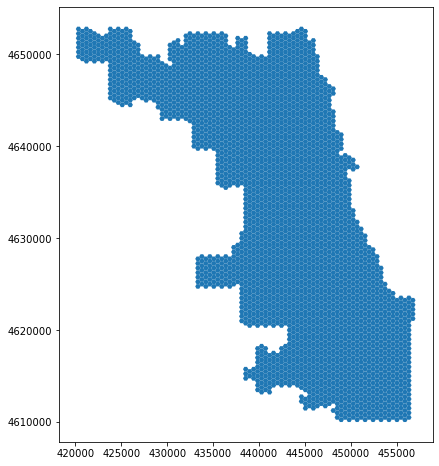

In [8]:
# load grid file and plot
grid_file = gpd.read_file('./data/raw/public/GridFile/Chicago_Grid.shp')
grid_file.plot(figsize=(8,8))

### Load and Plot the Street Network

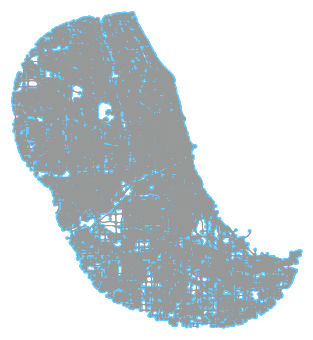

(<Figure size 531.74x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc2afdcf450>)

In [15]:
# load and plot street network, only pull from OSMNX drive if it doesn't exist locally
if not os.path.exists("data/raw/private/Chicago_Network_Buffer.graphml"):
    G = ox.graph_from_place('Chicago', network_type='drive', buffer_dist = 24140.2) # pulling the drive network the first time will take a while
    ox.save_graphml(G, 'raw/private/Chicago_Network_Buffer.graphml')
else:
    G = ox.load_graphml('raw/private/Chicago_Network_Buffer.graphml', node_type=str)
ox.plot_graph(G)

## "Helper" Functions

The functions below are needed for our analysis later, let's take a look!

### network_setting

Cleans the OSMNX network to work better with drive-time analysis.

First, we remove all nodes with 0 outdegree because any hospital assigned to such a node would be unreachable from everywhere. Next, we remove small (under 10 node) *strongly connected components* to reduce erroneously small ego-centric networks. Lastly, we ensure that the max speed is set and in the correct units before calculating time.

Args:

* network: OSMNX network for the spatial extent of interest

Returns:

* OSMNX network: cleaned OSMNX network for the spatial extent

In [ ]:
def network_setting(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component)<10:
            for node in component:
                _nodes_removed+=1
                network.remove_node(node)
    for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):
        if 'maxspeed' in data.keys():
            speed_type = type(data['maxspeed'])
            if (speed_type==str):
                # add in try/except blocks to catch maxspeed formats that don't fit Kang et al's cases
                try:
                    if len(data['maxspeed'].split(','))==2:
                        data['maxspeed_fix']=float(data['maxspeed'].split(',')[0])                  
                    elif data['maxspeed']=='signals':
                        data['maxspeed_fix']=35.0 # drive speed setting as 35 miles
                    else:
                        data['maxspeed_fix']=float(data['maxspeed'].split()[0])
                        # print("Warning: the value of", data['maxspeed'], "is being converted to 35.0")   
                except:
                    data['maxspeed_fix']= 35.0 #miles
            else:
                try:
                    data['maxspeed_fix']=float(data['maxspeed'][0].split()[0])
                except:
                    data['maxspeed_fix']= 35.0 #miles
        else:
            data['maxspeed_fix']= 35.0 #miles
        data['maxspeed_meters'] = data['maxspeed_fix']*26.8223 # convert mile to meter
        data['time'] = float(data['length'])/ data['maxspeed_meters']
    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))
    return(network)

### hospital_setting

Finds the nearest OSMNX node for each hospital.

Args:

* hospital: GeoDataFrame of hospitals
* G: OSMNX network

Returns:

* GeoDataFrame of hospitals with info on nearest OSMNX node

In [ ]:
def hospital_setting(hospitals, G):
    # create an empty column 
    hospitals['nearest_osm']=None
    # append the neaerest osm column with each hospitals neaerest osm node
    for i in tqdm(hospitals.index, desc="Find the nearest osm from hospitals", position=0):
        hospitals['nearest_osm'][i] = ox.get_nearest_node(G, [hospitals['Y'][i], hospitals['X'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

### pop_centroid

Converts geodata to centroids

Args:

* pop_data: a GeodataFrame
* pop_type: a string, either "pop" for general population or "covid" for COVID-19 case data

Returns:

* GeoDataFrame of centroids with population data

In [25]:
# to estimate the centroids of census tract / county
def pop_centroid (pop_data, pop_type):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    # if pop is selected in dropdown, select at risk pop where population is greater than 0
    if pop_type =="pop":
        pop_data=pop_data[pop_data['OverFifty']>=0] 
    # if covid is selected in dropdown, select where covid cases are greater than 0
    if pop_type =="covid":
        pop_data=pop_data[pop_data['cases']>=0]
    pop_cent = pop_data.centroid # it make the polygon to the point without any other information
    # convert to gdf
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    for point in tqdm(pop_cent, desc='Pop Centroid File Setting', position=0):
        if pop_type== "pop":
            pop = pop_data.iloc[i]['OverFifty']
            code = pop_data.iloc[i]['GEOID']
        if pop_type =="covid":
            pop = pop_data.iloc[i]['cases']
            code = pop_data.iloc[i].ZCTA5CE10
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
    return(pop_centroid)

### calculate_catchment_area

Calculates a catchment area of things within some distance of a point using a given metric.

Function first creates an ego-centric subgraph on the NetworkX road network starting with the nearest OSM node for the hospital and going out to a given distance as measured by the distance unit. We then calculate the convex hull around the nodes in the ego-centric subgraph and make it a GeoPandas object.

Args:

* G: OSMNX network
* nearest_osm: OSMNX road network node that is closest to the place of interest (hospital)
* distance: the max distance to include in the catchment area
* distance_unit: how we measure distance (used by ego_graph), we always use time

Returns:

* GeoDataFrame the catchment area.

In [ ]:
def calculate_catchment_area(G, nearest_osm, distance, distance_unit = "time"):
    # consutrct an ego graph based on distance unit for an input node
    road_network = nx.ego_graph(G, nearest_osm, distance, distance=distance_unit) 
    # create point geometries for all nodes in ego graph
    nodes = [Point((data['x'], data['y'])) for node, data in road_network.nodes(data=True)]
    # crate a single part geometry of all nodes
    polygon = gpd.GeoSeries(nodes).unary_union.convex_hull ## to create convex hull
    polygon = gpd.GeoDataFrame(gpd.GeoSeries(polygon)) ## change polygon to geopandas
    polygon = polygon.rename(columns={0:'geometry'}).set_geometry('geometry')
    return polygon.copy(deep=True)

### djikstra_catchment_area

Function written by Kufre Udoh. It is a more efficient way to calculate distance-weighted catchment areas for each hospital.

From Kufre: First, single_source_dijkstra returns a dictionary of identifiers for the nodes that compose the shortest paths from a given node. This dictionary of node identifiers is then used in subgraph to create a view of a larger graph, in our case the road network of Illinois, rather than creating a new graph with its own attributes as is done in ego_graph.

Args:

* G: OSMNX network
* nearest_osm: OSMNX road network node that is closest to the place of interest (hospital)
* distance: the max distance to include in the catchment area
* distance_unit: how we measure distance (used by ego_graph), we always use time

Returns:

* GeoDataFrame the catchment area.


In [ ]:
def dijkstra_cca(G, nearest_osm, distances, distance_unit = "time"):
    # creates subgraph (a list of nodes instead of writing a whole newe network graph)
    road_network = G.subgraph(nx.single_source_dijkstra_path_length(G, nearest_osm, distances, distance_unit)) 
    # creates an x and y point for each node
    nodes = [Point((data['x'], data['y'])) for node, data in road_network.nodes(data=True)]
    # constructs a multipart convex hull out of the subgraph of nodes
    polygon = gpd.GeoSeries(nodes).unary_union.convex_hull ## to create convex hull
    # turns the polygon into a geodatframme
    polygon = gpd.GeoDataFrame(gpd.GeoSeries(polygon)) ## change polygon to geopandas
    # renames geometry column
    polygon = polygon.rename(columns={0:'geometry'}).set_geometry('geometry')
    return polygon.copy(deep=True)

### hospital_measure_acc

Measures the effect of a single hospital on the surrounding area. (Uses `calculate_catchment_area` or `djikstra_cca`)

Args:

* \_thread\_id: int used to keep track of which thread this is
* hospital: Geopandas dataframe with information on a hospital
* pop_data: Geopandas dataframe with population data
* distances: Distances in time to calculate accessibility for
* weights: how to weight the different travel distances

Returns:

* Tuple containing:
    * Int (\_thread\_id)
    * GeoDataFrame of catchment areas with key stats

In [ ]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    ## weight = 1, 0.68, 0.22
    ## distances = 10 20 30
    # apply catchment calculation for each distance (10, 20, and 30 min)
    polygons = []
    for distance in distances:
        # append djikstra catchment calculation (uncomment to use)
        polygons.append(calculate_catchment_area(G, hospital['nearest_osm'],distance))
        # polygons.append(dijkstra_cca(G, hospital['nearest_osm'],distance))
    # clip the overlapping distance ploygons (create two donuts + hole)
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")
        
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        # multiply polygons by weights
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # to exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('\rCatchment for hospital {:4.0f} complete'.format(_thread_id), end="")
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ])

### measure_acc_par

Parallel implementation of accessibility measurement.

Args:

* hospitals: Geodataframe of hospitals
* pop_data: Geodataframe containing population data
* network: OSMNX street network
* distances: list of distances to calculate catchments for
* weights: list of floats to apply to different catchments
* num\_proc: number of processors to use.

Returns:

* Geodataframe of catchments with accessibility statistics calculated

In [ ]:
def hospital_acc_unpacker(args):
    return hospital_measure_acc(*args)

# parallel implementation fo previous function
def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
    pool = mp.Pool(processes = num_proc)
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
    return catchments

### overlap_calc

Calculates and aggregates accessibility statistics for one catchment on our grid file.

Args:

* \_id: thread ID
* poly: GeoDataFrame representing a catchment area
* grid_file: a GeoDataFrame representing our grids
* weight: the weight to applied for a given catchment
* service_type: the service we are calculating for: ICU beds or ventilators

Returns:

* Tuple containing:
    * thread ID
    * Counter object (dictionary for numbers) with aggregated stats by grid ID number

In [26]:
from collections import Counter
def overlap_calc(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    if type(poly.iloc[0][service_type])!=type(None):           
        value = float(poly[service_type])*weight
        # find polygons that overlap hex grids
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        # get the intersection's area
        intersect['overlapped']= intersect.area
        # divde overlapping areae by total area to get percent
        intersect['percent'] = intersect['overlapped']/intersect['area']
        # only choose intersecting catchments that make up greater than 50% of hexagon 
        intersect=intersect[intersect['percent']>=0.5]
        # pull id
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            try:
                value_dict[intersect_id] +=value
            except:
                value_dict[intersect_id] = value
    return(_id, value_dict)

def overlap_calc_unpacker(args):
    return overlap_calc(*args)

### overlapping_function

Calculates how all catchment areas overlap with and affect the accessibility of each grid in our grid file.

Args:

* grid_file: GeoDataFrame of our grid
* catchments: GeoDataFrame of our catchments
* service_type: the kind of care being provided (ICU beds vs. ventilators)
* weights: the weight to apply to each service type
* num\_proc: the number of processors

Returns:

* Geodataframe - grid\_file with calculated stats

In [ ]:
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file)

### normalization

Normalizes our result (Geodataframe) for a given resource (res).

In [ ]:
def normalization (result, res):
    result[res]=(result[res]-min(result[res]))/(max(result[res])-min(result[res]))
    return result

In [ ]:
def output_map(output_grid, base_map, hospitals, resource):
    ax=output_grid.plot(column=resource, 
                        cmap='PuBuGn',
                        figsize=(18,12), 
                        legend=True, 
                        zorder=1)
    # next two lines set bounds for our x- and y-axes because it looks like there's a weird 
    # point at the bottom left of the map that's messing up our frame (Maja)
    ax.set_xlim([314000, 370000])
    ax.set_ylim([540000, 616000])
    hospitals.plot(ax=ax, 
                   markersize=10, 
                   zorder=1, 
                   c='black', 
                   label='hospitals')

In [ ]:
def output_map_classified(output_grid, base_map, hospitals, resource):
    ax=output_grid.plot(column=resource, 
                        scheme='Equal_Interval', 
                        k=5, 
                        linewidth=0,
                        cmap='Blues', 
                        figsize=(18,12), 
                        legend=True, 
                        label="Acc Measure",
                        zorder=2)
    # next two lines set bounds for our x- and y-axes because it looks like there's a weird 
    # point at the bottom left of the map that's messing up our frame (Maja)
    ax.set_xlim([314000, 370000])
    ax.set_ylim([540000, 616000])
    hospitals.plot(ax=ax, 
                   markersize=10, 
                   zorder=1,
                   c='black',
                   legend=True,
                   label='hospitals')

### Run the model

Below you can customize the input of the model:

* Processor - the number of processors to use
* Region - the spatial extent of the measure
* Population - the population to calculate the measure for
* Resource - the hospital resource of interest

In [ ]:
import ipywidgets
from IPython.display import display

processor_dropdown = ipywidgets.Dropdown( options=[("1", 1), ("2", 2), ("3", 3), ("4", 4)],
    value = 4, description = "Processor: ")

place_dropdown = ipywidgets.Dropdown( options=[("Chicago", "Chicago"), ("Illinois","Illinois")],
    value = "Chicago", description = "Region: ")

population_dropdown = ipywidgets.Dropdown( options=[("Population at Risk", "pop"), ("COVID-19 Patients", "covid") ],
    value = "pop", description = "Population: ")

resource_dropdown = ipywidgets.Dropdown( options=[("ICU Beds", "hospital_icu_beds"), ("Ventilators", "hospital_vents") ],
    value = "hospital_icu_beds", description = "Resource: ")
display(processor_dropdown,place_dropdown,population_dropdown,resource_dropdown)

In [ ]:
%%time
G = network_setting (G)
# modify code to select pop valuee based on dropdown menu choice
if population_dropdown.value == "pop":
    pop_data = pop_centroid(atrisk_data, population_dropdown.value)
elif population_dropdown.value == "covid":
    pop_data = pop_centroid(covid_data, population_dropdown.value)
hospitals = hospital_setting(hospitals, G)
distances=[10,20,30] # distances in travel time
weights=[1.0, 0.68, 0.22] # weights where weights[0] is applied to distances[0]
resources = ["hospital_icu_beds", "hospital_vents"] # resources

In [ ]:
%%time
catchments = measure_acc_par(hospitals, pop_data, G, distances, weights, num_proc=processor_dropdown.value)

In [ ]:
for j in range(len(catchments)):
    catchments[j] = catchments[j][catchments[j][resource_dropdown.value]!=float('inf')]
result = overlapping_function(grid_file, catchments, resource_dropdown.value, weights, num_proc=processor_dropdown.value)

In [ ]:
result.head()

In [ ]:
result = normalization (result, resource_dropdown.value)

In [ ]:
# save output to geopackage -- will name the layer according the dropdown parameters
result.to_file('data/derived/public/results.gpkg', 
               layer='{}_{}'.format(population_dropdown.value,resource_dropdown.value), 
               driver='GPKG')

In [ ]:
# define variables to be used for spearman's rho correlation test (in 'Comparions with Original Results' section)
if (population_dropdown.value == "pop") & (resource_dropdown == "hospital_icu_beds"):
    rp_atrisk_icu = result['hospital_icu_beds']
elif (population_dropdown.value == "pop") & (resource_dropdown == "hospital_vents"):
    rp_atrisk_vents = result['hospital_vents']
elif (population_dropdown.value == "covid") & (resource_dropdown == "hospital_icu_beds"):
    rp_covid_icu = result['hospital_icu_beds'] 
elif (population_dropdown.value == "covid") & (resource_dropdown == "hospital_vents"):
    rp_covid_vents = result['hospital_vents']

### Plot distribution of results

In [ ]:
result['hospital_icu_beds'].plot.hist(bins=10)
plt.axvline(result['hospital_icu_beds'].mean(), color='k', linestyle='dashed', linewidth=1)
#plt.savefig('./results/figures/reproduction/{}_icu_histogram.png'.format(population_dropdown.value))

In [ ]:
result['hospital_vents'].plot.hist(bins=10)
plt.axvline(result['hospital_vents'].mean(), color='k', linestyle='dashed', linewidth=1)
# #plt.savefig('./results/figures/reproduction/{}_vents_histogram.png'.format(population_dropdown.value))

### Plot and Save Raw Output to RP-Result

In [ ]:
hospitals = hospitals.to_crs({'init': 'epsg:26971'})
result = result.to_crs({'init': 'epsg:26971'})
output_map(result, pop_data, hospitals, resource_dropdown.value)
plt.legend(bbox_to_anchor = (.3, .1), prop = {'size': 15}, frameon = False);
#plt.savefig('./results/figures/reproduction/{}_{}_continuous.png'.format(population_dropdown.value, resource_dropdown.value))

### Plot and Save Classified Outputs to RP-Result

In [ ]:
output_map_classified(result, pop_data, hospitals, resource_dropdown.value)
plt.legend(bbox_to_anchor = (.3, .1), 
           prop = {'size': 15}, 
           frameon = False)
#plt.savefig('./results/figures/reproduction/{}_{}_classified.png'.format(population_dropdown.value, resource_dropdown.value))

### Comparison with Original Results

In [ ]:
from scipy import stats

In [ ]:
# import study results to compare
## PROBLEM: doesn't specify whether thesee values refer to COVID or AT RISK Population .... 
fp = 'data/derived/public/Chicago_ACC.shp'
og_result = gpd.read_file(fp)

og_result.head()

In [ ]:
check = gpd.read_file('data/derived/public/ACC_Chicago_2018_ZIP_POP.shp')
check.head()

In [ ]:
# define orginal result variables to be used in plotting
og_icu = og_result['hospital_i']
og_vents = og_result['hospital_v']

In [ ]:
rp_covid_icu = result['hospital_icu_beds']

In [ ]:
## The authord only provide the results for the covid accessibility measurements
# calculate spearman rho value
icu_rho = stats.spearmanr(rp_covid_icu, og_icu)
vents_rho = stats.spearmanr(rp_covid_vents, og_vents)

In [ ]:
print("icu rho:", icu_rho)
print("vents rho:", vents_rho)

In [ ]:
# create subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4));

# ax11.scatter(rp_atrisk_icu, og_icu, s=1)
# ax11.set_xlabel("At Risk ICU", labelpad =5)
# ax12.scatter(rp_atrisk_vents, og_vents, s=1)
# ax12.set_xlabel("At Risk Vents", labelpad =5)
axs[0].scatter(rp_covid_icu, og_icu, s=1.5)
axs[0].set_xlabel("Covid ICU - Reproduction", labelpad=5)
axs[0].set_ylabel("Covid ICU - Original", labelpad =5)
axs[0].text(.45, .08, "correlation=0.8937208251590388, pvalue=0.0", fontsize=8)
axs[1].scatter(rp_covid_vents, og_vents, s=1.5)
axs[1].set_xlabel("Covid Vents - Reproduction", labelpad =5)
axs[1].set_ylabel("Covid Vents - Original", labelpad =5)
axs[1].text(.45, .08, "correlation=0.8933951605501842, pvalue=0.0", fontsize=8)

### Results & Discussion

to be written.

### Conclusion

to be written.

### References

Luo, W., & Qi, Y. (2009). An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health & place, 15(4), 1100-1107.